In [ ]:
# wn_tensors = wn_tensors.to(device)
# binary_yin = binary_yin.to(device)

In [ ]:
# https://www.kaggle.com/pinocookie/pytorch-dataset-and-dataloader/data
# https://discuss.pytorch.org/t/runtimeerror-multi-target-not-supported-newbie/10216/4

# Build the Dataset. We are going to generate a simple data set and then we will read it.
# Build the DataLoader.
# Build the model.
# Define the loss function and the optimizer.
# Train the model.
# Generate predictions.
# Plot the results. 

In [1]:
import logging
import numpy as np
import collections, gc

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from sklearn import preprocessing, metrics
from torch.utils.data import DataLoader, Dataset


# from scripts.utils.logger import Logger
from scripts.utils.data_reading import *
from scripts.utils.processing import *

logging.basicConfig(level=logging.INFO )

In [2]:
n = 16 # wn vector size  --> ~log_{2}(num_classes)

In [3]:
# N, T_leaves & PI_parents have to be present globally! (list of all the labels)
# one_hot_labels because I will keep accessing it for each document <1082>
p2c_table, c2p_table, _, _, PI_parents, T_leaves, N = lookup_table("swiki/data/cat_hier.txt", subset = False)

65333it [00:00, 257137.66it/s]


In [4]:
order_mapping = generate_order_mapping(N)
wn_tensors = generate_wn(N, n)
binary_yin = generate_binary_yin(N)

100%|████████████████████████████████████████████████████████████████████████| 50312/50312 [00:00<00:00, 189563.36it/s]


In [5]:
num_gpus = torch.cuda.device_count()

In [6]:
device = torch.device("cuda" if (torch.cuda.is_available() and num_gpus > 0) else "cpu")

In [7]:
device

device(type='cpu')

In [8]:
torch.cuda.manual_seed(123)

In [18]:
def too_hot_mapping(label):

    # order_mapping, wn_tensors & binary_yin HAVE TO BE A GLOBAL OBJECT
    
#     doc_labels = list(map(int, list(label)))
    w_n = []
    w_pi = []
    y_in = []
    
    try:
        int_rep = order_mapping[label]
        w_n.append(wn_tensors[int_rep-1])
        if label in T_leaves:
            y_in.append(binary_yin[int_rep-1])
            if label in c2p_table:
                pi_n = order_mapping[c2p_table[label][0]]
                w_pi.append(wn_tensors[pi_n-1])
    except:
        print("wait whaat?")
    
    w_n = list2tensor(w_n).to(device)
    w_pi = list2tensor(w_pi).to(device)
    y_in = list2tensor(y_in).to(device)
    
    return w_n, w_pi, y_in

In [19]:
class DatasetSWIKI(Dataset):
    
    def __init__(self, file_path, reduce = True, n_components = 128):
        self.reduce = reduce
        self.n_components = n_components
        self.data, self.labels = lower_dim(file_path, reduce, n_components)
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, index):
        
        if self.reduce:
            document = torch.from_numpy(self.data[index]).to(device)
        else:
            document = torch.from_numpy(self.data[index].todense()).to(device)
        
        label = self.labels[index]
        
        w_n, w_pi, y_in = too_hot_mapping(label)        
        
        return document, label, w_n, w_pi, y_in

In [20]:
n_components = 128

In [21]:
train_data = DatasetSWIKI("swiki/data/train_remapped_small.txt", reduce=True, n_components = n_components)
# valid_data = DatasetSWIKI("swiki/data/valid_remapped.txt", reduce=True, n_components = n_components)

In [22]:
len(train_data)

1396

In [23]:
batch_size = 32

In [24]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle = True)
# valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle = False)

In [28]:
train_iter = iter(train_loader)

doc, labs, w_n, w_pi, y_in = train_iter.next()

print('docs shape on batch size = {}'.format(doc.shape))
print('label shape on batch size = {}'.format(labs.shape))
print('w_n shape on batch size = {}'.format(w_n.shape))
print('w_pi shape on batch size = {}'.format(w_pi.shape))
print('y_in shape on batch size = {}'.format(y_in.shape))

docs shape on batch size = torch.Size([32, 128])
label shape on batch size = torch.Size([32])
w_n shape on batch size = torch.Size([32, 1, 16])
w_pi shape on batch size = torch.Size([32, 1, 16])
y_in shape on batch size = torch.Size([32, 1, 16])


In [29]:
train_data.__getitem__(0)

(tensor([ 9.8365, -5.0457, -1.7610, -0.1776, -2.7741,  2.3263, -0.2055,  1.7506,
          1.1513,  0.3741, -2.5467, -1.2244,  0.4956,  0.6239,  1.1025,  0.4333,
         -0.0221, -0.9534, -1.0785, -0.1622, -1.1985,  1.3402,  0.2410, -1.3047,
          0.8091,  1.4383, -0.9604,  0.8942,  1.6953, -0.5882, -0.7627,  0.2241,
          1.3576,  0.1927, -0.4254, -1.1699, -0.1532,  0.4774,  0.8600, -1.2309,
          0.4896,  0.3407, -0.1808,  0.6861,  0.5701,  0.3511, -1.0711,  1.4789,
          0.2393, -0.2528, -0.1849, -1.2790,  1.0678,  0.0774, -0.3383,  2.4926,
          0.3256, -1.9476,  0.2631, -1.7924, -1.8929, -0.3645,  0.0732,  1.4308,
          0.7945, -0.4393,  1.7312, -0.6344,  0.2225, -1.0386, -0.1363, -1.2747,
         -0.8533,  0.0650,  0.3359, -2.2044, -0.1062,  1.2255, -0.3418,  0.1249,
         -1.2310, -0.9614, -1.3562, -0.6249,  0.4060,  0.2473, -1.5463,  0.7643,
          0.4451, -1.7043,  0.2260, -1.0866,  1.5432,  0.4001, -0.6890,  0.3798,
         -0.1583, -0.6503, -

In [138]:
# Hyper Parameters 
input_size = train_data.data.shape[1] #2085164 -> 128

num_classes = n #50312 --> n (16)
num_epochs = 30 # TRAIN IT FOR A LOT OF EPOCHS!!!
learning_rate = 0.001

In [139]:
# Model
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(input_size, num_classes, False)
        
    def forward(self, x, wn):
        x1 = self.linear1(x)
        return x1*(wn)

In [140]:
model = LogisticRegression().to(device)

In [141]:
model

LogisticRegression(
  (linear1): Linear(in_features=128, out_features=16, bias=False)
)

In [142]:
criterion = nn.SoftMarginLoss(reduction='mean') 
L2Loss = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate)

In [143]:
total_step = len(train_loader)

In [144]:
torch.cuda.empty_cache()

In [145]:
# torch.cuda.memory_cached()-torch.cuda.memory_allocated()

In [146]:
nn.parameter.Parameter(torch.mean(0.5*torch.sqrt(torch.sum((labels-pis)**2, dim=1))**2))*1e-2

tensor(0.0134, grad_fn=<MulBackward0>)

In [147]:
for m in model.parameters():
    print(type(m))
    print(m.shape)
    print(m.norm(p=2))

<class 'torch.nn.parameter.Parameter'>
torch.Size([16, 128])
tensor(2.2950, grad_fn=<NormBackward0>)


In [148]:
# Training the Model
losses = []

for epoch in range(num_epochs):
    train_iter = iter(train_loader)
    for i, (document, all_labels, labels, pis, y_ins) in enumerate(train_iter):
        
        document = Variable(document).float().to(device) 
        
        labels = Variable(labels).float().to(device).view(-1, n)
        pis = pis.view(-1, n)
        y_ins = y_ins.view(-1, n)
        
        # todo: make this better i.e. better label embeddings that actually embed hierarchy
        # ideas: skipgram/cbow uses context-word pair to create embeddings. try similarly for
        # label hierarchy - i.e. parent-child relationship - use this to create label embeddings
        # maybe this way l2_reg value will be low. right now it needs to be of atleast 1e-3 order
        # to get nice curve. [OR] start with a fixed random vector initialization for the root node
        # and then as you traverse through the tree add v.v.v.small amount of randomness to the children
        # till you reach the leaf.
        l2_reg = nn.parameter.Parameter(torch.mean(0.5*torch.sqrt(torch.sum((labels-pis)**2, dim=1))**2))*1e-3
        
        if type(optimizer) != torch.optim.LBFGS:            
            optimizer.zero_grad()
            w_xi = model(document, labels)
            loss1 = criterion(w_xi, y_ins) + l2_reg
            
            if (i+1) % 40 == 0: 
                print ('Epoch [{}/{}], step:[{}/{}], loss: {:.6f}'.format(epoch+1, num_epochs, i+1, total_step, loss1.item()))
                torch.cuda.empty_cache()

            losses.append(loss1.item())
            loss1.backward()
            optimizer.step()

        else:
            def closure():               
                optimizer.zero_grad()
                w_xi = model(document, labels)
                loss1 = criterion(w_xi, y_ins) 
                
                if (i+1) % 40 == 0: 
                    print ('Epoch [{}/{}], step:[{}/{}], loss: {:.6f}'.format(epoch+1, num_epochs, i+1, total_step, loss1.item()))
                    torch.cuda.empty_cache()
                
                losses.append(loss1.item())
                loss1.backward()
                return loss1
            optimizer.step(closure)


Epoch [1/30], step:[40/44], loss: 0.701780
Epoch [1/30], step:[40/44], loss: 0.701776
Epoch [1/30], step:[40/44], loss: 0.701670
Epoch [1/30], step:[40/44], loss: 0.701461
Epoch [1/30], step:[40/44], loss: 0.701159
Epoch [1/30], step:[40/44], loss: 0.700785
Epoch [1/30], step:[40/44], loss: 0.700378
Epoch [1/30], step:[40/44], loss: 0.699948
Epoch [1/30], step:[40/44], loss: 0.699492
Epoch [1/30], step:[40/44], loss: 0.699007
Epoch [1/30], step:[40/44], loss: 0.698487
Epoch [1/30], step:[40/44], loss: 0.697928
Epoch [1/30], step:[40/44], loss: 0.697341
Epoch [1/30], step:[40/44], loss: 0.696745
Epoch [1/30], step:[40/44], loss: 0.696138
Epoch [1/30], step:[40/44], loss: 0.695504
Epoch [1/30], step:[40/44], loss: 0.694851
Epoch [1/30], step:[40/44], loss: 0.694196
Epoch [1/30], step:[40/44], loss: 0.693538
Epoch [1/30], step:[40/44], loss: 0.692863
Epoch [2/30], step:[40/44], loss: 0.689873
Epoch [2/30], step:[40/44], loss: 0.689846
Epoch [2/30], step:[40/44], loss: 0.689708
Epoch [2/30

Epoch [10/30], step:[40/44], loss: 0.670789
Epoch [10/30], step:[40/44], loss: 0.669994
Epoch [10/30], step:[40/44], loss: 0.669203
Epoch [10/30], step:[40/44], loss: 0.668447
Epoch [10/30], step:[40/44], loss: 0.667655
Epoch [10/30], step:[40/44], loss: 0.666843
Epoch [10/30], step:[40/44], loss: 0.666043
Epoch [10/30], step:[40/44], loss: 0.665224
Epoch [10/30], step:[40/44], loss: 0.664428
Epoch [10/30], step:[40/44], loss: 0.663645
Epoch [11/30], step:[40/44], loss: 0.675747
Epoch [11/30], step:[40/44], loss: 0.675734
Epoch [11/30], step:[40/44], loss: 0.675646
Epoch [11/30], step:[40/44], loss: 0.675503
Epoch [11/30], step:[40/44], loss: 0.675274
Epoch [11/30], step:[40/44], loss: 0.674955
Epoch [11/30], step:[40/44], loss: 0.674545
Epoch [11/30], step:[40/44], loss: 0.674150
Epoch [11/30], step:[40/44], loss: 0.673725
Epoch [11/30], step:[40/44], loss: 0.673230
Epoch [11/30], step:[40/44], loss: 0.672747
Epoch [11/30], step:[40/44], loss: 0.672250
Epoch [11/30], step:[40/44], los

Epoch [19/30], step:[40/44], loss: 0.641565
Epoch [19/30], step:[40/44], loss: 0.640958
Epoch [19/30], step:[40/44], loss: 0.640280
Epoch [19/30], step:[40/44], loss: 0.639651
Epoch [20/30], step:[40/44], loss: 0.668756
Epoch [20/30], step:[40/44], loss: 0.668742
Epoch [20/30], step:[40/44], loss: 0.668604
Epoch [20/30], step:[40/44], loss: 0.668354
Epoch [20/30], step:[40/44], loss: 0.668030
Epoch [20/30], step:[40/44], loss: 0.667698
Epoch [20/30], step:[40/44], loss: 0.667283
Epoch [20/30], step:[40/44], loss: 0.666839
Epoch [20/30], step:[40/44], loss: 0.666366
Epoch [20/30], step:[40/44], loss: 0.665797
Epoch [20/30], step:[40/44], loss: 0.665181
Epoch [20/30], step:[40/44], loss: 0.664568
Epoch [20/30], step:[40/44], loss: 0.663917
Epoch [20/30], step:[40/44], loss: 0.663224
Epoch [20/30], step:[40/44], loss: 0.662473
Epoch [20/30], step:[40/44], loss: 0.661687
Epoch [20/30], step:[40/44], loss: 0.660897
Epoch [20/30], step:[40/44], loss: 0.660096
Epoch [20/30], step:[40/44], los

Epoch [29/30], step:[40/44], loss: 0.632031
Epoch [29/30], step:[40/44], loss: 0.631872
Epoch [29/30], step:[40/44], loss: 0.631655
Epoch [29/30], step:[40/44], loss: 0.631380
Epoch [29/30], step:[40/44], loss: 0.631049
Epoch [29/30], step:[40/44], loss: 0.630691
Epoch [29/30], step:[40/44], loss: 0.630315
Epoch [29/30], step:[40/44], loss: 0.629889
Epoch [29/30], step:[40/44], loss: 0.629441
Epoch [29/30], step:[40/44], loss: 0.628983
Epoch [29/30], step:[40/44], loss: 0.628512
Epoch [29/30], step:[40/44], loss: 0.628045
Epoch [29/30], step:[40/44], loss: 0.627573
Epoch [29/30], step:[40/44], loss: 0.627095
Epoch [29/30], step:[40/44], loss: 0.626601
Epoch [29/30], step:[40/44], loss: 0.626077
Epoch [29/30], step:[40/44], loss: 0.625542
Epoch [29/30], step:[40/44], loss: 0.625014
Epoch [30/30], step:[40/44], loss: 0.650448
Epoch [30/30], step:[40/44], loss: 0.650438
Epoch [30/30], step:[40/44], loss: 0.650221
Epoch [30/30], step:[40/44], loss: 0.649948
Epoch [30/30], step:[40/44], los

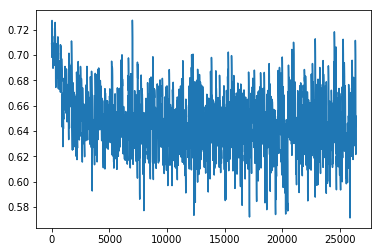

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses);

In [ ]:
labels.t().mm(document)

In [ ]:
losses[-469]

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    for documents, _, labels in valid_data:
        docs = Variable(torch.from_numpy(documents)).float()
        outputs = model(docs)
        print(torch.sum(torch.where(outputs>0.0001, torch.tensor(1), torch.tensor(0)), dim=0))
        print(torch.sum(torch.where(labels>0, torch.tensor(1), torch.tensor(0)), dim=0))

        umm, predicted = torch.max(outputs.data, 1)
        print(umm.shape)
        total += labels.size(0)
        correct += (predicted == labels).sum()

    print('Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))

In [ ]:
# Save the model checkpoint
torch.save(model.state_dict(), 'train_valid_model.ckpt')

In [ ]:
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
writer = SummaryWriter()

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')

fig = plt.figure()

c1 = plt.Circle((0.2, 0.5), 0.2, color='r')
c2 = plt.Circle((0.8, 0.5), 0.2, color='r')

ax = plt.gca()
ax.add_patch(c1)
ax.add_patch(c2)
plt.axis('scaled')


# from tensorboardX import SummaryWriter
# writer = SummaryWriter()
writer.add_figure('matplotlib', fig)
writer.close()

In [ ]:
# #         Forward + Backward + Optimize
#         def closure():
#             optimizer.zero_grad()
#             outputs = model(document)
#             loss = criterion(outputs, torch.max(labels, 1)[0])
# #             print('loss:', loss.item())
#             loss.backward()
#             return loss
#         optimizer.step(closure)


In [ ]:
import umap # fit should get a sparse matrix
%time trans = umap.UMAP(n_neighbors=5, random_state=42, n_components=32, verbose=True).fit(train_data.data)
trans.embedding_

In [ ]:
167593,441685 160318:1 227881:1 255720:1 265934:1 432905:2 515946:1 538188:1 586136:1 610561:1 692683:1 
                                        735075:1 828325:1 874107:1 898766:1 1087064:1 1354716:1 1432746:1 
                                        1454292:1 1463839:1 1626714:1 1715083:1 1839104:1 1864180:1 2023750:1 
